In [36]:
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")

from pandas_profiling import ProfileReport

import warnings

warnings.filterwarnings("ignore")

In [37]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (
    selection_rate,
    false_positive_rate,
    true_positive_rate,
    count,
)


from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from xgboost import XGBRegressor, XGBClassifier
from catboost import CatBoostClassifier
import shap

from category_encoders.target_encoder import TargetEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from tqdm.notebook import tqdm
from collections import defaultdict

In [38]:
# Synthetic dataset
## Info about this data can be found in Quantile Encoder https://link.springer.com/chapter/10.1007%2F978-3-030-85529-1_14
df = pd.read_csv("data/cauchy.csv")

This dataset has 100k rows. And 3 columns = target, category1 and category2.
- Category 1 has 100 unique valuess
- Category 2 has 10 unique values

In [64]:
# Binarize the target
df["Score"] = df["target"]
df.loc[df["target"] > df.target.mean(), "Score"] = 1
df.loc[df["target"] <= df.target.mean(), "Score"] = 0
# Convert to string
df.value_2 = df.value_2.astype(str)
df.value_1 = df.value_1.astype(str)
# Split
X = df[["value_1", "value_2"]]
y = df[["Score"]]

In [65]:
y.value_counts()

Score
1.0      52410
0.0      47590
dtype: int64

In [66]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

In [67]:
te = CatBoostEncoder(sigma=3)
model = XGBClassifier()
pipe = Pipeline([("encoder", te), ("model", model)])

pipe.fit(X_tr, y_tr)

preds = pipe.predict(X_te)

[09:14:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [68]:
gm = MetricFrame(
    metrics=accuracy_score,
    y_true=y_te,
    y_pred=preds,
    sensitive_features=X_te["value_2"],
)

print(gm.by_group)
print(gm.overall)

value_2
101    0.970194
102    0.985039
103    0.974602
104    0.971593
105    0.962126
106    0.921143
107    0.707586
108    0.947599
109    0.972873
110    0.982553
Name: accuracy_score, dtype: object
0.9256060606060607


In [69]:
def fit_predict(modelo, enc, data, target, test):
    pipe = Pipeline([("encoder", enc), ("model", modelo)])
    pipe.fit(data, target)
    return pipe.predict(test)


def auc_group(model, data, y_true, dicc, group: str = ""):
    aux = data.copy()
    aux["target"] = y_true
    cats = aux[group].unique().tolist()
    cats = cats + ["all"]

    if len(dicc) == 0:
        dicc = defaultdict(list, {k: [] for k in cats})

    for cat in cats:
        if cat != "all":
            aux2 = aux[aux[group] == cat]
            preds = model.predict_proba(aux2.drop(columns="target"))[:, 1]
            truth = aux2["target"]
            dicc[cat].append(roc_auc_score(truth, preds))
        else:
            dicc[cat].append(roc_auc_score(y_true, model.predict_proba(data)[:, 1]))

    return dicc

In [72]:
df.value_2.unique()

array(['101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110'], dtype=object)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Auc: [0.9583984225989843, 0.966010722461629, 0.9647774838429133, 0.9644089812465055, 0.9642236080977549, 0.9655071137196616, 0.9650351155786758, 0.9646805979214934, 0.9650629234836267, 0.9641205855894202, 0.9647232705762714, 0.9630036328999468, 0.9626066579391173, 0.9648859324634926, 0.9633241931810077, 0.9653698651064446, 0.9642329289364278, 0.9602443977645816, 0.9625272890835843, 0.9643950386412632]


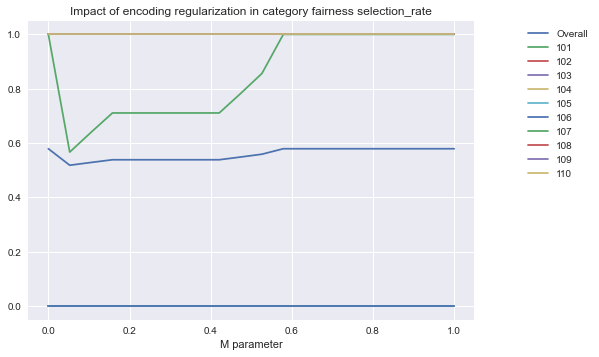

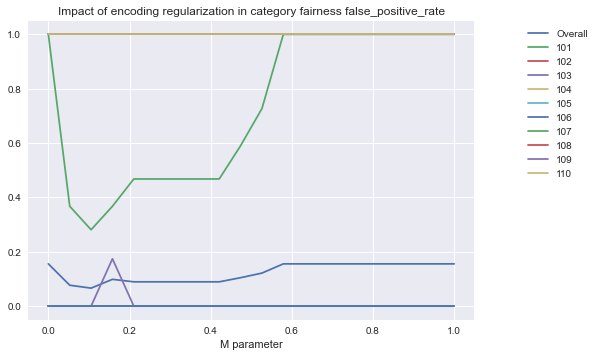

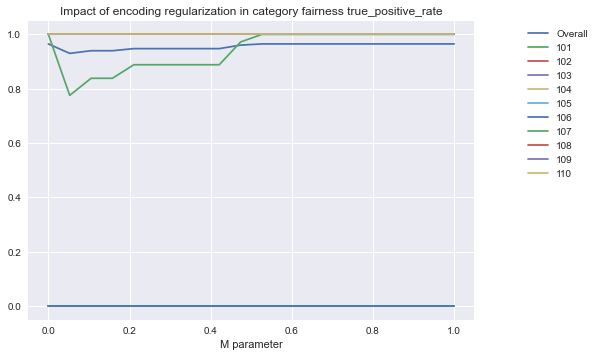

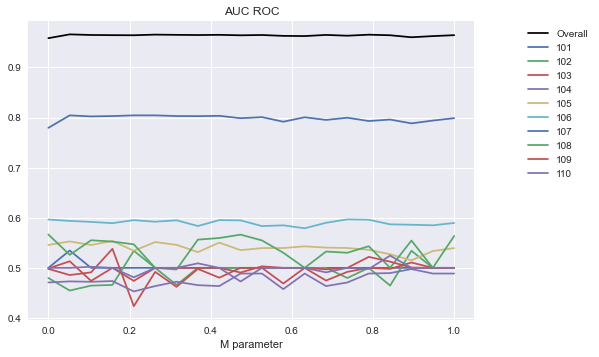

In [87]:
for metrics in [selection_rate, false_positive_rate, true_positive_rate]:
    gms = []
    gms_rec = []
    ms = []
    auc = {}

    # param = [0, 0.5, 1, 2, 5, 10, 20, 50, 100]
    param = np.linspace(0, 1, 20)
    for m in tqdm(param):
        # encoder = MEstimateEncoder(m=m)
        # encoder = TargetEncoder(smoothing=m)
        encoder = LeaveOneOutEncoder(sigma=m)

        # model = LogisticRegression()
        model = GradientBoostingClassifier()

        pipe = Pipeline([("encoder", encoder), ("model", model)])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_te)

        gm = MetricFrame(
            metrics=metrics,
            y_true=y_te,
            y_pred=preds,
            sensitive_features=X_te["value_2"],
        )
        auc = auc_group(model=pipe, data=X_te, y_true=y_te, dicc=auc, group="value_2")

        gms.append(gm)
        ms.append(m)

    # Fairness
    plt.figure()
    title = "Impact of encoding regularization in category fairness " + str(
        metrics.__name__
    )
    plt.title(title)
    plt.xlabel("M parameter")
    plt.plot(ms, [gm.overall for gm in gms], label="Overall")

    for element in X["value_2"].unique():
        plt.plot(ms, [gm.by_group[element] for gm in gms], label=element)

    plt.legend(bbox_to_anchor=(1.1, 1))
    plt.show()

# Accuracy (AUC)
plt.figure()
plt.title("AUC ROC")
plt.xlabel("M parameter")
print("Auc:", auc["all"])
plt.plot(ms, auc["all"], label="Overall", color="k")
for element in X["value_2"].unique():
    plt.plot(ms, auc[element], label=element)

plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()